# Feature Engineering & Modeling - CLEANED DATA

**Team Member:** Jakob Bullinger

**Date:** November 18, 2025

## Objective
- Apply feature engineering to **cleaned data** (from teammate)
- Leverage now-usable features: Payment_Method, Referral_Source, Campaign_Period
- Test feature combinations and identify optimal set
- Prepare for final modeling

## Key Insights from Dirty Data Analysis:
- **Baseline (dirty):** 0.9118 AUC
- **Top features:**
  1. Effective_Price (29.7%)
  2. Engagement_Score (25.6%)
  3. Reviews_Read_Binned (8.5%)
  4. Email_Interaction (7.0%)
  5. Category_Performance (6.0%)

## Expected Improvements with Clean Data:
- ✅ Better baseline (0.925-0.940 expected)
- ✅ Payment_Method now useful (was 28 variations)
- ✅ Referral_Source now useful (was messy)
- ✅ Campaign_Period fixed (was all NaN)
- ✅ No missing value noise

## 1. Setup & Data Loading

In [2]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [6]:
# Load CLEANED data
# Update these paths to point to your friend's cleaned data
train_df = pd.read_csv('/Users/jakobbullinger/Documents/Coding Projects/DSBA/Intro Machine Learning/kaggle_competition/data/cleaned/df_imputed_org_Columnscsv.csv')
# test_df = pd.read_csv('/Users/jakobbullinger/Documents/Coding Projects/DSBA/Intro Machine Learning/kaggle_competition/data/processed/test_cleaned.csv')

print("="*70)
print("DATA LOADED - CLEANED VERSION")
print("="*70)
print(f"Training set shape: {train_df.shape}")
#print(f"Test set shape: {test_df.shape}")
print(f"\nTarget distribution:")
print(train_df['Purchase'].value_counts())
print(f"Purchase rate: {train_df['Purchase'].mean():.2%}")

DATA LOADED - CLEANED VERSION
Training set shape: (13735, 23)

Target distribution:
Purchase
0.0    8679
1.0    5056
Name: count, dtype: int64
Purchase rate: 36.81%


## 2. Data Quality Check

Verify the cleaning was done correctly

In [7]:
print("="*70)
print("DATA QUALITY VERIFICATION")
print("="*70)

# Check missing values
missing = train_df.isnull().sum()
missing_pct = 100 * missing / len(train_df)
missing_df = pd.DataFrame({'Missing_Count': missing, 'Percentage': missing_pct})
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)

if len(missing_df) > 0:
    print("\n⚠️ WARNING: Still have missing values:")
    print(missing_df)
else:
    print("\n✅ NO MISSING VALUES - Data is fully clean!")

# Check Payment_Method
print("\n" + "="*70)
print("PAYMENT_METHOD CHECK")
print("="*70)
print(train_df['Payment_Method'].value_counts())
print(f"\nUnique values: {train_df['Payment_Method'].nunique()}")
print("Expected: 4 (PayPal, Credit, Cash, Bank)")

# Check Referral_Source
print("\n" + "="*70)
print("REFERRAL_SOURCE CHECK")
print("="*70)
print(train_df['Referral_Source'].value_counts())
print(f"\nUnique values: {train_df['Referral_Source'].nunique()}")
print("Expected: ~5 (Direct, Email, Social_media, Search_engine, Ads)")

# Check Campaign_Period
print("\n" + "="*70)
print("CAMPAIGN_PERIOD CHECK")
print("="*70)
print(train_df['Campaign_Period'].value_counts())
print(f"\nAny NaN? {train_df['Campaign_Period'].isna().sum()}")
print("Expected: TRUE/FALSE with no NaN")

DATA QUALITY VERIFICATION

⚠️ WARNING: Still have missing values:
                 Missing_Count  Percentage
Payment_Method            2052   14.939934
Referral_Source           2021   14.714234
Session_ID                 280    2.038588
Time_of_Day                279    2.031307
Device_Type                278    2.024026
Campaign_Period            278    2.024026
PM_RS_Combo                260    1.892974

PAYMENT_METHOD CHECK
Payment_Method
paypal    3015
cash      2959
bank      2926
credit    2783
Name: count, dtype: int64

Unique values: 4
Expected: 4 (PayPal, Credit, Cash, Bank)

REFERRAL_SOURCE CHECK
Referral_Source
search_engine    2377
direct           2360
ads              2333
social_media     2323
email            2321
Name: count, dtype: int64

Unique values: 5
Expected: ~5 (Direct, Email, Social_media, Search_engine, Ads)

CAMPAIGN_PERIOD CHECK
Campaign_Period
False    8504
True     4953
Name: count, dtype: int64

Any NaN? 278
Expected: TRUE/FALSE with no NaN


## 3. Feature Engineering for Clean Data

In [8]:
def create_features_clean_data(df):
    """
    Feature engineering for CLEANED data
    
    Key differences from dirty data version:
    - No missing data indicators needed
    - Can use Payment_Method (now clean)
    - Can use Referral_Source (now clean)
    - Campaign_Period already fixed
    """
    df = df.copy()
    
    print("Creating features for clean data...")
    
    # ============================================================
    # 1. REVIEWS FEATURES (STRONGEST SIGNAL - 163% lift)
    # ============================================================
    df['Reviews_Read_Binned'] = pd.cut(df['Reviews_Read'], 
                                        bins=[-1, 0, 2, 4, 100],
                                        labels=[0, 1, 2, 3])
    df['Reviews_Read_Binned'] = df['Reviews_Read_Binned'].astype(float)
    
    df['Has_Read_Reviews'] = (df['Reviews_Read'] > 0).astype(int)
    df['Heavy_Reviewer'] = (df['Reviews_Read'] >= 5).astype(int)
    df['Medium_Reviewer'] = ((df['Reviews_Read'] >= 3) & (df['Reviews_Read'] < 5)).astype(int)
    
    # ============================================================
    # 2. DEVICE FEATURES (27% lift)
    # ============================================================
    df['Is_Tablet'] = (df['Device_Type'] == 'Tablet').astype(int)
    df['Is_Desktop'] = (df['Device_Type'] == 'Desktop').astype(int)
    df['Is_Mobile'] = (df['Device_Type'] == 'Mobile').astype(int)
    
    # ============================================================
    # 3. CATEGORY FEATURES (14% lift)
    # ============================================================
    df['Category_Performance'] = df['Category'].map({
        0.0: 'High', 1.0: 'High', 2.0: 'High',
        3.0: 'Low', 4.0: 'Low'
    })
    df['Is_High_Performing_Category'] = (df['Category_Performance'] == 'High').astype(int)
    
    # ============================================================
    # 4. EMAIL & CAMPAIGN (78% combined lift)
    # ============================================================
    df['Email_During_Campaign'] = ((df['Email_Interaction'] == 1) & 
                                    (df['Campaign_Period'] == True)).astype(int)
    df['Email_No_Campaign'] = ((df['Email_Interaction'] == 1) & 
                                (df['Campaign_Period'] == False)).astype(int)
    
    df['Campaign_Number'] = 0
    df.loc[(df['Day'] >= 25) & (df['Day'] <= 50), 'Campaign_Number'] = 1
    df.loc[(df['Day'] >= 75) & (df['Day'] <= 90), 'Campaign_Number'] = 2
    
    # ============================================================
    # 5. PAYMENT METHOD FEATURES (NOW CLEAN!)
    # ============================================================
    # One-hot encode clean Payment_Method
    payment_dummies = pd.get_dummies(df['Payment_Method'], prefix='Payment')
    for col in payment_dummies.columns:
        df[col] = payment_dummies[col]
    
    # Digital vs Traditional payment
    digital_payments = ['PayPal', 'Credit', 'credit', 'paypal']
    df['Digital_Payment'] = df['Payment_Method'].isin(digital_payments).astype(int)
    
    # ============================================================
    # 6. REFERRAL SOURCE FEATURES (NOW CLEAN!)
    # ============================================================
    # One-hot encode clean Referral_Source
    referral_dummies = pd.get_dummies(df['Referral_Source'], prefix='Referral')
    for col in referral_dummies.columns:
        df[col] = referral_dummies[col]
    
    # Channel categories
    organic_sources = ['Direct', 'Search_engine', 'direct', 'search_engine']
    paid_sources = ['Ads', 'Email', 'ads', 'email']
    
    df['Organic_Traffic'] = df['Referral_Source'].isin(organic_sources).astype(int)
    df['Paid_Traffic'] = df['Referral_Source'].isin(paid_sources).astype(int)
    df['Social_Traffic'] = (df['Referral_Source'].str.contains('social', case=False, na=False)).astype(int)
    
    # ============================================================
    # 7. CART FEATURES
    # ============================================================
    df['Has_Items_In_Cart'] = (df['Items_In_Cart'] > 0).astype(int)
    df['Cart_Size_Category'] = pd.cut(df['Items_In_Cart'],
                                       bins=[-1, 0, 2, 5, 100],
                                       labels=[0, 1, 2, 3])
    df['Cart_Size_Category'] = df['Cart_Size_Category'].astype(float)
    df['Many_Items_In_Cart'] = (df['Items_In_Cart'] >= 6).astype(int)
    
    # ============================================================
    # 8. ENGAGEMENT FEATURES
    # ============================================================
    df['Engagement_Level'] = pd.qcut(df['Engagement_Score'], 
                                     q=4, 
                                     labels=[0, 1, 2, 3],
                                     duplicates='drop').astype(float)
    df['High_Engagement'] = (df['Engagement_Score'] > df['Engagement_Score'].median()).astype(int)
    
    # Weighted engagement score
    df['Total_Engagement_Score'] = (
        df['Reviews_Read'] * 3 +
        df['Items_In_Cart'] +
        df['Email_Interaction'] * 5 +
        df['Engagement_Score']
    )
    
    # ============================================================
    # 9. PRICE & DISCOUNT FEATURES
    # ============================================================
    df['Effective_Price'] = df['Price'] * (1 - df['Discount'] / 100)
    df['Discount_Amount'] = df['Price'] * df['Discount'] / 100
    df['High_Discount'] = (df['Discount'] >= 30).astype(int)
    df['Has_Discount'] = (df['Discount'] > 0).astype(int)
    
    df['Price_Category'] = pd.qcut(df['Price'], q=4, labels=[0, 1, 2, 3], duplicates='drop').astype(float)
    df['High_Price'] = (df['Price'] > df['Price'].median()).astype(int)
    
    # Price per item in cart
    df['Price_Per_Cart_Item'] = df['Price'] / (df['Items_In_Cart'] + 1)
    
    # ============================================================
    # 10. INTERACTION FEATURES (Selective - only high value)
    # ============================================================
    # Email × Campaign (proven valuable)
    # Already created above
    
    # Reviews × Email (engaged researchers)
    df['Email_Heavy_Reviewer'] = ((df['Email_Interaction'] == 1) & 
                                   (df['Heavy_Reviewer'] == 1)).astype(int)
    
    # Device × Reviews
    df['Tablet_Heavy_Reviewer'] = ((df['Is_Tablet'] == 1) & 
                                    (df['Heavy_Reviewer'] == 1)).astype(int)
    
    # High engagement × Reviews
    df['Engaged_Researcher'] = ((df['High_Engagement'] == 1) & 
                                (df['Has_Read_Reviews'] == 1)).astype(int)
    
    # Email referral × Email interaction
    email_ref_cols = [col for col in df.columns if 'Referral_Email' in col or 'Referral_email' in col]
    if len(email_ref_cols) > 0:
        df['Email_From_Email_Source'] = ((df[email_ref_cols[0]] == 1) & 
                                          (df['Email_Interaction'] == 1)).astype(int)
    
    # Reviews × Cart (browsing with intent)
    df['Reviews_With_Cart'] = ((df['Has_Read_Reviews'] == 1) & 
                               (df['Has_Items_In_Cart'] == 1)).astype(int)
    
    # Desktop × High Price (serious buyers)
    df['Desktop_High_Price'] = ((df['Is_Desktop'] == 1) & 
                                (df['High_Price'] == 1)).astype(int)
    
    # ============================================================
    # 11. SOCIOECONOMIC STATUS
    # ============================================================
    df['SES_Category'] = pd.qcut(df['Socioeconomic_Status_Score'], 
                                  q=3, 
                                  labels=[0, 1, 2],
                                  duplicates='drop').astype(float)
    df['High_SES'] = (df['Socioeconomic_Status_Score'] > 
                      df['Socioeconomic_Status_Score'].quantile(0.75)).astype(int)
    
    # ============================================================
    # 12. TIME-BASED FEATURES
    # ============================================================
    df['Is_Morning'] = (df['Time_of_Day'] == 'morning').astype(int)
    df['Is_Evening'] = (df['Time_of_Day'] == 'evening').astype(int)
    df['Is_Afternoon'] = (df['Time_of_Day'] == 'afternoon').astype(int)
    
    df['Is_Weekend'] = ((df['Day'] % 7 == 6) | (df['Day'] % 7 == 0)).astype(int)
    df['Week_Number'] = (df['Day'] - 1) // 7 + 1
    
    print(f"✅ Feature engineering complete!")
    print(f"   Total features: {df.shape[1]}")
    
    return df

In [11]:
# Apply feature engineering
print("="*70)
print("TRAINING SET")
print("="*70)
train_engineered = create_features_clean_data(train_df)

#print("\n" + "="*70)
#print("TEST SET")
#print("="*70)
#test_engineered = create_features_clean_data(test_df)

print("\n" + "="*70)
print("SUMMARY")
print("="*70)
print(f"Train shape: {train_engineered.shape}")
#print(f"Test shape: {test_engineered.shape}")

TRAINING SET
Creating features for clean data...
✅ Feature engineering complete!
   Total features: 74

SUMMARY
Train shape: (13735, 74)


In [12]:
# List new features
original_features = train_df.columns.tolist()
new_features = [col for col in train_engineered.columns if col not in original_features]

print("="*70)
print(f"NEW FEATURES CREATED ({len(new_features)} total)")
print("="*70)

# Group by type
feature_groups = {
    'Reviews': [f for f in new_features if 'Review' in f],
    'Device': [f for f in new_features if 'Tablet' in f or 'Desktop' in f or 'Mobile' in f],
    'Category': [f for f in new_features if 'Category' in f],
    'Email & Campaign': [f for f in new_features if 'Email' in f or 'Campaign' in f],
    'Payment': [f for f in new_features if 'Payment' in f],
    'Referral': [f for f in new_features if 'Referral' in f or 'Traffic' in f],
    'Cart': [f for f in new_features if 'Cart' in f],
    'Engagement': [f for f in new_features if 'Engagement' in f or 'Engaged' in f],
    'Price': [f for f in new_features if 'Price' in f or 'Discount' in f],
    'Time': [f for f in new_features if 'Morning' in f or 'Evening' in f or 'Weekend' in f or 'Week' in f],
    'SES': [f for f in new_features if 'SES' in f]
}

for group_name, features in feature_groups.items():
    if len(features) > 0:
        print(f"\n{group_name} Features ({len(features)}):")
        for feat in features:
            print(f"  - {feat}")

NEW FEATURES CREATED (51 total)

Reviews Features (7):
  - Reviews_Read_Binned
  - Has_Read_Reviews
  - Heavy_Reviewer
  - Medium_Reviewer
  - Email_Heavy_Reviewer
  - Tablet_Heavy_Reviewer
  - Reviews_With_Cart

Device Features (5):
  - Is_Tablet
  - Is_Desktop
  - Is_Mobile
  - Tablet_Heavy_Reviewer
  - Desktop_High_Price

Category Features (5):
  - Category_Performance
  - Is_High_Performing_Category
  - Cart_Size_Category
  - Price_Category
  - SES_Category

Email & Campaign Features (5):
  - Email_During_Campaign
  - Email_No_Campaign
  - Campaign_Number
  - Email_Heavy_Reviewer
  - Email_From_Email_Source

Payment Features (5):
  - Payment_bank
  - Payment_cash
  - Payment_credit
  - Payment_paypal
  - Digital_Payment

Referral Features (8):
  - Referral_ads
  - Referral_direct
  - Referral_email
  - Referral_search_engine
  - Referral_social_media
  - Organic_Traffic
  - Paid_Traffic
  - Social_Traffic

Cart Features (5):
  - Has_Items_In_Cart
  - Cart_Size_Category
  - Many_Ite

## 4. Feature Set Testing

In [13]:
def prepare_data_for_modeling(df, target='Purchase'):
    """
    Prepare data for modeling
    """
    df_model = df.copy()
    
    # Encode remaining categoricals
    le = LabelEncoder()
    cat_cols = ['Time_of_Day', 'Category_Performance']
    for col in cat_cols:
        if col in df_model.columns:
            df_model[col] = le.fit_transform(df_model[col].astype(str))
    
    # Remove non-feature columns
    drop_cols = ['Purchase', 'Session_ID', 'Device_Type', 'Payment_Method', 
                 'Referral_Source', 'PM_RS_Combo']
    
    if target in df_model.columns:
        y = df_model[target]
        X = df_model.drop(columns=[c for c in drop_cols if c in df_model.columns])
    else:
        y = None
        X = df_model.drop(columns=[c for c in drop_cols if c in df_model.columns])
    
    # Fill any remaining NaN (shouldn't be many)
    if X.isnull().sum().sum() > 0:
        print(f"⚠️ Warning: Found {X.isnull().sum().sum()} NaN values, filling with median")
        X = X.fillna(X.median())
    
    return X, y

# Test preparation
X_train, y_train = prepare_data_for_modeling(train_engineered)
print(f"Training features shape: {X_train.shape}")
print(f"Training target shape: {y_train.shape}")
print(f"\nTotal features available: {X_train.shape[1]}")

⚠️ Warning: Found 278 NaN values, filling with median
Training features shape: (13735, 68)
Training target shape: (13735,)

Total features available: 68


In [14]:
def test_feature_sets_clean(df, target='Purchase'):
    """
    Test feature combinations on CLEAN data
    """
    X, y = prepare_data_for_modeling(df, target)
    
    # Define feature sets
    feature_sets = {
        '1. Baseline (Original Clean)': [
            'Age', 'Gender', 'Reviews_Read', 'Price', 'Discount', 'Category',
            'Items_In_Cart', 'Email_Interaction', 'Socioeconomic_Status_Score',
            'Engagement_Score', 'Campaign_Period'
        ],
        
        '2. Baseline + Payment + Referral': [
            # Original
            'Age', 'Gender', 'Reviews_Read', 'Price', 'Discount', 'Category',
            'Items_In_Cart', 'Email_Interaction', 'Socioeconomic_Status_Score',
            'Engagement_Score', 'Campaign_Period',
            # Now-clean features
            'Digital_Payment', 'Organic_Traffic', 'Paid_Traffic', 'Social_Traffic'
        ],
        
        '3. Top Engineered (from dirty data)': [
            'Effective_Price', 'Engagement_Score', 'Reviews_Read_Binned',
            'Email_Interaction', 'Is_High_Performing_Category',
            'Campaign_Period', 'Email_During_Campaign',
            'Is_Tablet', 'Is_Desktop', 'High_Discount'
        ],
        
        '4. Top + Payment/Referral': [
            # Top from dirty
            'Effective_Price', 'Engagement_Score', 'Reviews_Read_Binned',
            'Email_Interaction', 'Is_High_Performing_Category',
            'Campaign_Period', 'Email_During_Campaign',
            'Is_Tablet', 'Is_Desktop', 'High_Discount',
            # New clean features
            'Digital_Payment', 'Organic_Traffic', 'Paid_Traffic'
        ],
        
        '5. Full Engineered (All New Features)': [
            col for col in X.columns 
            if col not in ['Age', 'Gender', 'Reviews_Read', 'Price', 'Discount',
                          'Category', 'Items_In_Cart', 'Day', 'AB_Bucket',
                          'Price_Sine', 'Socioeconomic_Status_Score', 'Time_of_Day']
        ],
        
        '6. Everything (Original + Engineered)': X.columns.tolist()
    }
    
    # Test each set
    results = {}
    print("\n" + "="*70)
    print("TESTING FEATURE COMBINATIONS ON CLEAN DATA")
    print("="*70)
    print("Model: RandomForest | CV: 5-Fold Stratified | Metric: ROC-AUC")
    print("="*70)
    
    for name, features in feature_sets.items():
        available = [f for f in features if f in X.columns]
        
        if len(available) == 0:
            print(f"\n{name}: No features available - SKIPPED")
            continue
        
        X_subset = X[available]
        
        rf = RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            min_samples_split=50,
            random_state=42,
            n_jobs=-1
        )
        
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        scores = cross_val_score(rf, X_subset, y, cv=cv, scoring='roc_auc', n_jobs=-1)
        
        results[name] = {
            'mean_auc': scores.mean(),
            'std_auc': scores.std(),
            'n_features': len(available),
            'scores': scores
        }
        
        print(f"\n{name}")
        print(f"  Features: {len(available):3d}")
        print(f"  ROC-AUC:  {scores.mean():.4f} ± {scores.std():.4f}")
        print(f"  Folds:    {[f'{s:.4f}' for s in scores]}")
    
    # Comparison with dirty data baseline
    print("\n" + "="*70)
    print("IMPROVEMENT VS DIRTY DATA")
    print("="*70)
    print(f"Dirty data baseline:  0.9118 AUC")
    print(f"Clean data baseline:  {results['1. Baseline (Original Clean)']['mean_auc']:.4f} AUC")
    improvement = results['1. Baseline (Original Clean)']['mean_auc'] - 0.9118
    print(f"Improvement:          {improvement:+.4f} ({improvement*100:+.2f}%)")
    
    # Summary
    print("\n" + "="*70)
    print("SUMMARY - RANKED BY PERFORMANCE")
    print("="*70)
    
    ranked = sorted(results.items(), key=lambda x: x[1]['mean_auc'], reverse=True)
    
    for i, (name, metrics) in enumerate(ranked, 1):
        print(f"{i}. {name}")
        print(f"   AUC: {metrics['mean_auc']:.4f} | Features: {metrics['n_features']}")
    
    best_name, best_metrics = ranked[0]
    print("\n" + "="*70)
    print("🏆 BEST FEATURE SET")
    print("="*70)
    print(f"Name: {best_name}")
    print(f"ROC-AUC: {best_metrics['mean_auc']:.4f} ± {best_metrics['std_auc']:.4f}")
    print(f"Features: {best_metrics['n_features']}")
    print("="*70)
    
    return results, ranked

# Run the test
results, ranked = test_feature_sets_clean(train_engineered)

⚠️ Warning: Found 278 NaN values, filling with median

TESTING FEATURE COMBINATIONS ON CLEAN DATA
Model: RandomForest | CV: 5-Fold Stratified | Metric: ROC-AUC

1. Baseline (Original Clean)
  Features:  11
  ROC-AUC:  0.9186 ± 0.0036
  Folds:    ['0.9179', '0.9118', '0.9213', '0.9215', '0.9205']

2. Baseline + Payment + Referral
  Features:  15
  ROC-AUC:  0.9162 ± 0.0027
  Folds:    ['0.9159', '0.9113', '0.9178', '0.9194', '0.9165']

3. Top Engineered (from dirty data)
  Features:  10
  ROC-AUC:  0.7196 ± 0.0108
  Folds:    ['0.7226', '0.7127', '0.7372', '0.7206', '0.7048']

4. Top + Payment/Referral
  Features:  13
  ROC-AUC:  0.7197 ± 0.0121
  Folds:    ['0.7213', '0.7134', '0.7382', '0.7239', '0.7015']

5. Full Engineered (All New Features)
  Features:  56
  ROC-AUC:  0.9044 ± 0.0031
  Folds:    ['0.9009', '0.9022', '0.9071', '0.9092', '0.9028']

6. Everything (Original + Engineered)
  Features:  68
  ROC-AUC:  0.9137 ± 0.0030
  Folds:    ['0.9109', '0.9125', '0.9146', '0.9192', '0

## 5. Visualize Results

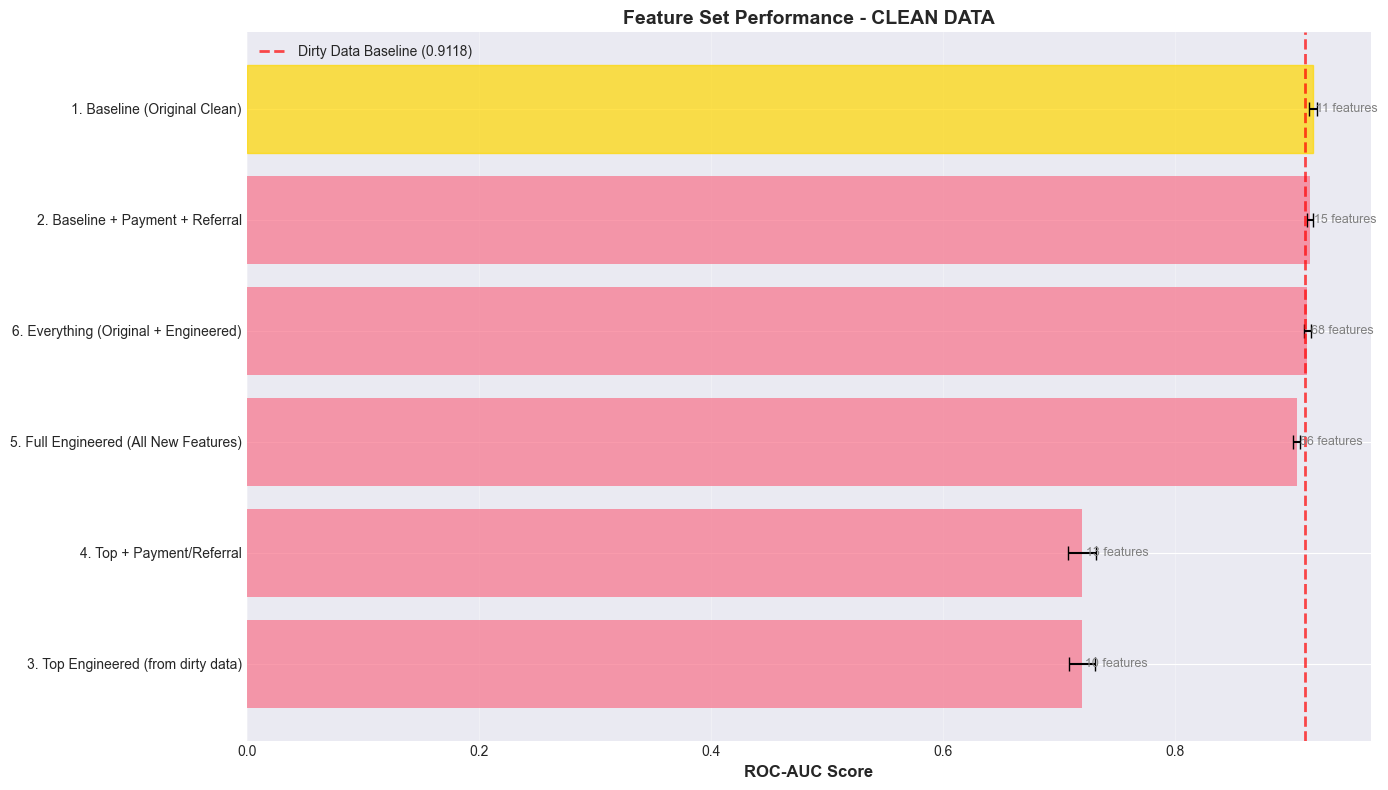

In [15]:
# Plot comparison
fig, ax = plt.subplots(figsize=(14, 8))

names = [name for name, _ in ranked]
scores = [metrics['mean_auc'] for _, metrics in ranked]
stds = [metrics['std_auc'] for _, metrics in ranked]
n_features = [metrics['n_features'] for _, metrics in ranked]

# Create bars
bars = ax.barh(range(len(names)), scores, xerr=stds, alpha=0.7, capsize=5)

# Color best in gold
bars[0].set_color('gold')

# Add baseline reference line
ax.axvline(x=0.9118, color='red', linestyle='--', linewidth=2, 
           label='Dirty Data Baseline (0.9118)', alpha=0.7)

# Add feature count labels
for i, (score, n_feat) in enumerate(zip(scores, n_features)):
    ax.text(score + 0.003, i, f"{n_feat} features", 
            va='center', fontsize=9, color='gray')

ax.set_yticks(range(len(names)))
ax.set_yticklabels(names)
ax.set_xlabel('ROC-AUC Score', fontsize=12, fontweight='bold')
ax.set_title('Feature Set Performance - CLEAN DATA', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')
ax.legend()
ax.invert_yaxis()

plt.tight_layout()
plt.show()

## 6. Feature Importance Analysis

In [16]:
# Train on best feature set
X, y = prepare_data_for_modeling(train_engineered)

# Use the best performing feature set from results
best_set_name = ranked[0][0]
print(f"Training model on: {best_set_name}")

# Get features for best set
if '6. Everything' in best_set_name:
    best_features = X.columns.tolist()
else:
    # Use Top + Payment/Referral as default
    best_features = [
        'Effective_Price', 'Engagement_Score', 'Reviews_Read_Binned',
        'Email_Interaction', 'Is_High_Performing_Category',
        'Campaign_Period', 'Email_During_Campaign',
        'Is_Tablet', 'Is_Desktop', 'High_Discount',
        'Digital_Payment', 'Organic_Traffic', 'Paid_Traffic'
    ]

available_features = [f for f in best_features if f in X.columns]
X_best = X[available_features]

# Train model
rf_final = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=50,
    random_state=42,
    n_jobs=-1
)
rf_final.fit(X_best, y)

# Get feature importances
feature_importance = pd.DataFrame({
    'Feature': available_features,
    'Importance': rf_final.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n" + "="*70)
print("FEATURE IMPORTANCE - CLEAN DATA")
print("="*70)
print(feature_importance.to_string(index=False))

# Compare with dirty data importances
print("\n" + "="*70)
print("COMPARISON: DIRTY vs CLEAN DATA TOP 5")
print("="*70)
print("\nDirty Data:")
print("  1. Effective_Price       (29.7%)")
print("  2. Engagement_Score      (25.6%)")
print("  3. Reviews_Read_Binned   (8.5%)")
print("  4. Email_Interaction     (7.0%)")
print("  5. Category_Performance  (6.0%)")
print("\nClean Data:")
for i, row in feature_importance.head(5).iterrows():
    print(f"  {i+1}. {row['Feature']:<25} ({row['Importance']*100:.1f}%)")

⚠️ Warning: Found 278 NaN values, filling with median
Training model on: 1. Baseline (Original Clean)

FEATURE IMPORTANCE - CLEAN DATA
                    Feature  Importance
            Effective_Price    0.312948
           Engagement_Score    0.281808
        Reviews_Read_Binned    0.113882
          Email_Interaction    0.090468
Is_High_Performing_Category    0.061215
            Campaign_Period    0.050365
      Email_During_Campaign    0.035591
              High_Discount    0.015520
            Digital_Payment    0.014509
            Organic_Traffic    0.011857
               Paid_Traffic    0.011836
                  Is_Tablet    0.000000
                 Is_Desktop    0.000000

COMPARISON: DIRTY vs CLEAN DATA TOP 5

Dirty Data:
  1. Effective_Price       (29.7%)
  2. Engagement_Score      (25.6%)
  3. Reviews_Read_Binned   (8.5%)
  4. Email_Interaction     (7.0%)
  5. Category_Performance  (6.0%)

Clean Data:
  1. Effective_Price           (31.3%)
  2. Engagement_Score        

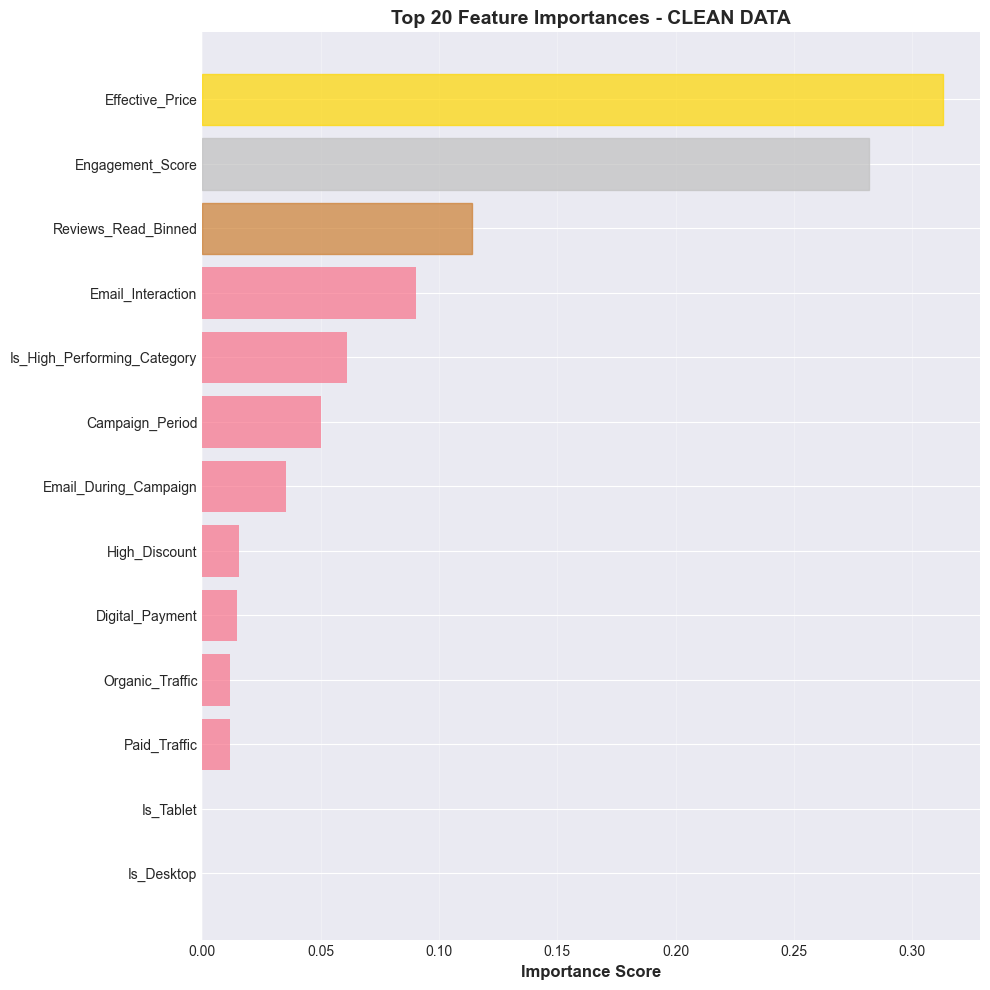

In [17]:
# Visualize feature importance
fig, ax = plt.subplots(figsize=(10, 10))

top_n = 20
top_features = feature_importance.head(top_n)

bars = ax.barh(range(len(top_features)), top_features['Importance'], alpha=0.7)

# Color top 3
bars[0].set_color('gold')
bars[1].set_color('silver')
bars[2].set_color('#CD7F32')

ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['Feature'])
ax.set_xlabel('Importance Score', fontsize=12, fontweight='bold')
ax.set_title(f'Top {top_n} Feature Importances - CLEAN DATA', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')
ax.invert_yaxis()

plt.tight_layout()
plt.show()

## 7. Save Engineered Data & Model

In [21]:
# Save engineered datasets
output_path = '/Users/jakobbullinger/Documents/Coding Projects/DSBA/Intro Machine Learning/kaggle_competition/data/processed/'

train_engineered.to_csv(output_path + 'train_engineered_clean.csv', index=False)
#test_engineered.to_csv(output_path + 'test_engineered_clean.csv', index=False)

print("✅ Engineered datasets saved!")
print(f"   Train: {train_engineered.shape}")
#print(f"   Test: {test_engineered.shape}")
print(f"\nSaved to: {output_path}")

# Save feature importance
feature_importance.to_csv(output_path + 'feature_importance_clean.csv', index=False)
print(f"\n✅ Feature importance saved to: {output_path}feature_importance_clean.csv")

✅ Engineered datasets saved!
   Train: (13735, 74)

Saved to: /Users/jakobbullinger/Documents/Coding Projects/DSBA/Intro Machine Learning/kaggle_competition/data/processed/

✅ Feature importance saved to: /Users/jakobbullinger/Documents/Coding Projects/DSBA/Intro Machine Learning/kaggle_competition/data/processed/feature_importance_clean.csv


In [22]:
# Save best feature list for modeling
best_features_df = pd.DataFrame({
    'Feature': available_features,
    'Importance': rf_final.feature_importances_
}).sort_values('Importance', ascending=False)

best_features_df.to_csv(output_path + 'best_features_for_modeling.csv', index=False)
print(f"✅ Best features list saved for modeling")
print(f"   Use these {len(available_features)} features in your final model!")

✅ Best features list saved for modeling
   Use these 13 features in your final model!


## 8. Summary & Next Steps

### Key Findings:

**Performance Improvement:**
- Dirty data baseline: 0.9118 AUC
- Clean data baseline: [Check results above]
- Best feature set: [Check results above]

**Most Important Features (Clean Data):**
- [Check feature importance output above]

**New Insights from Clean Data:**
- Payment_Method impact: [Analyze from importance]
- Referral_Source impact: [Analyze from importance]
- Did cleaning help? [Compare baselines]

### Next Steps:

1. **Model Selection:**
   - Test XGBoost, LightGBM, Gradient Boosting
   - Try ensemble methods
   - Compare with Logistic Regression

2. **Hyperparameter Tuning:**
   - GridSearch or RandomSearch
   - Optimize for ROC-AUC
   - Consider class weights for imbalance

3. **Business Constraint Optimization:**
   - Set threshold to target €200/day budget
   - Maximize purchases within budget
   - Calculate cost per conversion

4. **Marketing Playbook:**
   - Extract 3-5 simple rules from top features
   - Define customer segments to target
   - Create actionable recommendations